# **Speech-To-Text Using HMM and GMM Models**

## Hi, I’m Daivik Patel — an AI/ML enthusiast with a passion for building, experimenting with, and optimizing machine learning models.

This project was developed as part of my mid-term academic assessment, with the specific requirement of not using any pre-trained models or neural networks. Instead, I implemented traditional techniques in Natural Language Processing (NLP) and Audio Processing to build a speech recognition system.

The system leverages two classical machine learning models:

- Hidden Markov Model (HMM) for sequence modelling  

- Gaussian Mixture Model (GMM) for probabilistic classification

The goal was to classify spoken words using only fundamental signal processing and statistical modelling methods — demonstrating that effective speech recognition is possible even without deep learning.

## First, we will install some packages which are required for this project

1) `sounddevice` - To record audio from your microphone in real-time, so we can capture raw audio directly from your PC’s mic and save the audio as NumPy arrays (which we later convert to .wav).

2) `scipy` - It saves the Numpy array from `sounddevice` into an actual `.wav` file.

3) `librosa` - It converts `.wav` into MFCC (Mel-Frequency Cepstral Coefficients), which converts raw sound into machine-readable numbers.

4) `numpy` - The foundation for numerical operations and array handling. All the audio data, MFCCs, and intermediate steps are handled using NumPy arrays. This will be used throughout data prep, training, and model prediction.

5) `matplotlib` - For visualizing the audio waveform or MFCCs. Also helps for debugging and understanding what features we are extracting. Plotting spectrograms, MFCC matrices, etc.

6) `hmmlearn` - To build the actual Hidden Markov Models (HMM) that will learn and decode speech patterns. This is the core engine that maps speech features to text without neural networks or pretrained models.
- It allows you to:

   - Train a model using sequences (like MFCCs).

   - Use GaussianHMM to model acoustic features.

   - Apply Viterbi decoding to predict the best word/digit. (Not explicitly, but when we call the HMM model.score() it internally uses the log-likelihood computation, which is based on the Viterbi algorithm )

In [ ]:
pip install sounddevice scipy librosa numpy matplotlib hmmlearn

We have to patched `np.complex` to ensure compatibility between newer NumPy versions (≥1.24) and older Librosa versions that still rely on deprecated NumPy aliases.

In [1]:
# PATCH numpy for librosa compatibility
import numpy as np
import warnings # lets us suppress or handle userwarning messages.
warnings.filterwarnings("ignore", category=UserWarning)

if not hasattr(np, 'complex'):
    np.complex = complex

### Required libraries

In [2]:
import os
import librosa
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sounddevice as sd

### Defining Paths for the project

In [3]:
DATASET_PATH = r"C:\Users\Daivik\Desktop\NLP-sem-2\Best Project\Unziped" # Where all words folds are saved
FEATURE_SAVE_PATH = r"C:\Users\Daivik\Desktop\NLP-sem-2\Best Project\Extracted Features" # Where your extracted features are going to be saved
MODEL_SAVE_DIR = r"C:\Users\Daivik\Desktop\NLP-sem-2\Best Project\Trained models" # Where your trained models will be saved
NOISE_FOLDER = os.path.join(DATASET_PATH, "_background_noise_") # This constructs the path to the _background_noise_ folder inside your dataset
FEATURES_FILE = os.path.join(FEATURE_SAVE_PATH, "features.pkl") # Full path (including filename) for saving or loading the extracted audio features in pickle format.

 This `load_noise_files` function loads all background noise `.wav` files from **NOISE_FOLDER** into a list of audio signals (Numpy arrays), which we will use to add noise in the dataset randomly to improve model robustness.

 `sr` stands for sampling rate. The number of samples of audio recorded per second. 16,000 Hz (or 16 kHz) is a common sampling rate for voice datasets (like Google Speech Commands). We want all the noise files to be consistent.

In [ ]:
# Loading background noise
def load_noise_files(folder):
    noises = []
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            signal, _ = librosa.load(path, sr=16000)
            noises.append(signal)
    return noises

noise_samples = load_noise_files(NOISE_FOLDER)

This `add_noise` function will add noise randomly from the noise (that we have created by `load_noise_files` function) list by selecting one noise sample from the list to the original signals of audio files (word .wav numpy array). The noise folder provided by the dataset contains noise files, which are bigger in length compared to the word files (which are 1 or 2 seconds long), so we are trimming the noise files randomly to the same length as the word files.
`noise_level` = 0.2, we can change this. This is the parameter with which we can add strong or weak noise to the original signals.

In [4]:
# Adding background noise
def add_noise(signal, noise_list, noise_level=0.2):
    noise = random.choice(noise_list)
    if len(noise) < len(signal):
        signal = signal[:len(noise)]
        noise_segment = noise
    else:
        start = random.randint(0, len(noise) - len(signal))
        noise_segment = noise[start:start + len(signal)]
    return signal + noise_level * noise_segment

This `normalize_features` function combines MFCC (core speech features), delta (1st-order derivative (captures changes), and delta² (2nd-order derivative (acceleration of changes)) features, and normalizes them so that all values are on the same scale using `standardscalar` (mean= 0, standard deviation =1). This improves model stability and accuracy during training and prediction by preventing features with larger values from dominating.

In [5]:
# Normalizing MFCC + delta + delta2 
def normalize_features(mfcc, delta, delta2):
    features = np.concatenate((mfcc, delta, delta2), axis=1)
    scaler = StandardScaler()
    return scaler.fit_transform(features)

### **What is MFCC, delta and delta2 ?**

**1** `MFCC` - Stands for Mel-Frequency Cepstral Coefficients, it is the most commonly used feature in speech and audio processing. It captures the spectral shape of the sound using the Mel scale, which mimics how humans perceive pitch and best feature for speech recognition.

**2** `delta` - It calculates the rate of change of MFCCs over time. It detects transitions in speech (like going from "s" to "h" in "sheila").

**3** `delta2` - It measures the rate of change of the delta features (i.e., acceleration). Helps model from rapid shifts or slurred/fast speech patterns.

This `extract_features_from_folder` function loads a word folder and loads .wav files from that folder. It adds noise from the noise list that we have created into the data with a probability of 30%, which means our 30 % data has extra noise inside it to simulate real-world conditions. Then we are extracting 13 MFCC features per frame and transposing to shape `(time_steps, 13)` to be compatible with our models. We are manually setting a safe, odd-sized window for computing delta features based on signal length, usually between 3–9 frames. After that, our delta will be calculated and normalized with standardscalar (mfcc + delta + delta2).

In [6]:
# Extracting features from the word folder
def extract_features_from_folder(folder_path, label, noise_list, apply_noise_prob=0.3):
    features = []
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            path = os.path.join(folder_path, file)
            signal, sr = librosa.load(path, sr=16000)

            if random.random() < apply_noise_prob:
                signal = add_noise(signal, noise_list, noise_level=0.2)

            mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T
            width = max(3, (min(9, mfcc.shape[0]) // 2) * 2 + 1)
            delta = librosa.feature.delta(mfcc.T, width=width).T
            delta2 = librosa.feature.delta(mfcc.T, order=2, width=width).T
            combined = normalize_features(mfcc, delta, delta2)
            features.append((combined, label))
    return features

This `extract_silence_class` function we are adding because when we don't say anything into the mic, the model will still try to predict words, so we want when we don't speak into the mic it add a class (label) called silence.

This function will generate synthetic "silence" training data from background noise list and randomly select 1-second noise segments, then extract MFCC + delta + delta² features, normalize them and label them as "silence". This helps the model learn to recognize silence vs. spoken words, reducing false predictions during live use.

In [7]:
# Extracting features for "silence" class
def extract_silence_class(noise_list, count=100):
    silence_features = []
    for _ in range(count):
        noise = random.choice(noise_list)
        if len(noise) < 16000:
            continue
        start = random.randint(0, len(noise) - 16000)
        segment = noise[start:start + 16000]
        mfcc = librosa.feature.mfcc(y=segment, sr=16000, n_mfcc=13).T
        width = max(3, (min(9, mfcc.shape[0]) // 2) * 2 + 1)
        delta = librosa.feature.delta(mfcc.T, width=width).T
        delta2 = librosa.feature.delta(mfcc.T, order=2, width=width).T
        combined = normalize_features(mfcc, delta, delta2)
        silence_features.append((combined, "silence"))
    return silence_features

This block handles feature extraction and caching. It goes through each word folder, extracts MFCC + delta + delta² features, adds synthetic silence samples, and saves everything in a .pkl file. If the file already exists, it simply loads the features instead of recomputing them.
This saves time and ensures consistent training data.

In [8]:
# Extracting features and saving them
os.makedirs(FEATURE_SAVE_PATH, exist_ok=True)
if not os.path.exists(FEATURES_FILE):
    print("🔍 Extracting features from dataset...")
    data = []
    for word in os.listdir(DATASET_PATH):
        full_path = os.path.join(DATASET_PATH, word)
        if os.path.isdir(full_path) and word != "_background_noise_":
            print(f"📁 Processing word: {word}")
            data += extract_features_from_folder(full_path, word, noise_samples)
    data += extract_silence_class(noise_samples, count=100)
    with open(FEATURES_FILE, "wb") as f:
        pickle.dump(data, f)
else:
    print("🔁 Loading existing features...")
    with open(FEATURES_FILE, "rb") as f:
        data = pickle.load(f)

🔍 Extracting features from dataset...
📁 Processing word: backward
📁 Processing word: bed
📁 Processing word: bird
📁 Processing word: cat
📁 Processing word: dog
📁 Processing word: down
📁 Processing word: eight
📁 Processing word: five
📁 Processing word: follow
📁 Processing word: forward
📁 Processing word: four
📁 Processing word: go
📁 Processing word: happy
📁 Processing word: house
📁 Processing word: learn
📁 Processing word: left
📁 Processing word: marvin
📁 Processing word: nine
📁 Processing word: no
📁 Processing word: off
📁 Processing word: on
📁 Processing word: one
📁 Processing word: right
📁 Processing word: seven
📁 Processing word: sheila
📁 Processing word: six
📁 Processing word: stop
📁 Processing word: three
📁 Processing word: tree
📁 Processing word: two
📁 Processing word: up
📁 Processing word: visual
📁 Processing word: wow
📁 Processing word: yes
📁 Processing word: zero


In [9]:
# Checking one sample from the extracted features
sample_mfcc, sample_label = data[0]

print(f"Label: {sample_label}")
print(f"MFCC shape: {sample_mfcc.shape}")  # Should be (time_steps, 39) → (time_steps, 13 MFCC + 13 Delta + 13 Delta2)

Label: backward
MFCC shape: (32, 39)


This heatmap represents the audio features over time for the spoken word "backward".

X-axis (Time): Shows how the features evolve over seconds (typical length of a spoken word).

Y-axis (Feature index): Represents the 39 combined features (MFCC + delta + delta²). Each row is one feature.

Color (dB level): Yellow/bright → higher intensity/energy (e.g., strong frequencies). Purple/dark → lower intensity (quiet or no energy)

Around 0.5s, we can see brighter vertical bands — these are likely key phonetic transitions in the word "backward".

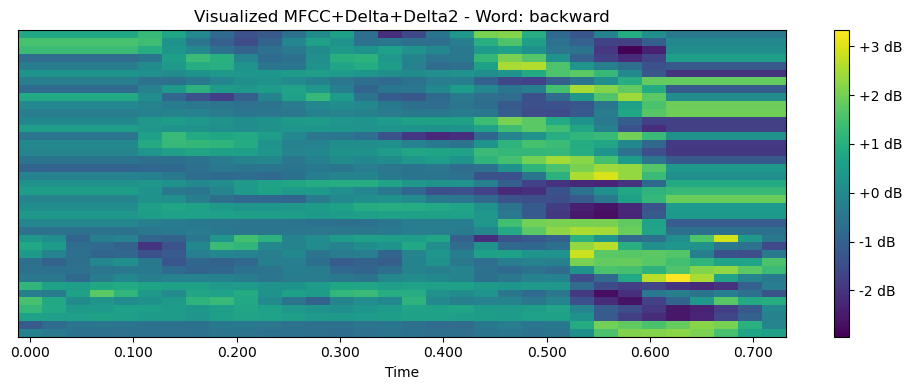

In [12]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_mfcc.T, x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Visualized MFCC+Delta+Delta2 - Word: {sample_label}")
plt.tight_layout()
plt.show()

In [13]:
# Splitting the data into train and validation sets
train_data, val_data = train_test_split(
    data,
    test_size=0.2,
    stratify=[label for _, label in data],
    random_state=42
)

print(f"🧠 Training samples: {len(train_data)}")
print(f"🧪 Validation samples: {len(val_data)}")

🧠 Training samples: 84743
🧪 Validation samples: 21186


### **What is Gaussian HMM?**

A Gaussian Hidden Markov Model (Gaussian HMM) is a powerful statistical model used extensively in speech and audio processing.

A Hidden Markov Model (HMM) is a sequence model with two main layers:

**Hidden States** — represent unknown, underlying parts of the process (e.g., phonemes in speech).

**Observations** — the actual data we can see (e.g., MFCC features extracted from audio).

A Gaussian HMM means the observations are modelled using Gaussian (normal) distributions in each hidden state. Because speech/audio features (like MFCCs) are continuous and vary smoothly, a Gaussian distribution is a natural fit to model them in each state, so in each state the model learns the mean and variance of your MFCC vectors. We have trained total 35 models.

This `train_hmm_models` function trains a separate Hidden Markov Model (HMM) for each word in the dataset using MFCC features and groups the features by label, then concatenates all samples of each label and trains a Gaussian HMM on that group. After that it stores and returns all trained models in a dictionary.Each trained HMM will later be used to score incoming audio and predict the best-matching word.

In [63]:
# Training HMM
NUM_STATES = 7
print("🔄 Training HMM Models...")
def train_hmm_models(train_data, n_states=NUM_STATES):
    models = {}
    grouped = defaultdict(list)
    for mfcc, label in train_data:
        grouped[label].append(mfcc)
    for label, sequences in grouped.items():
        X = np.concatenate(sequences)
        lengths = [len(seq) for seq in sequences]
        model = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=100, verbose=True)
        model.fit(X, lengths)
        models[label] = model
    return models

hmm_models = train_hmm_models(train_data)

🔄 Training HMM Models...


NameError: name 'train_data' is not defined

 Scenic, I accidentally ran this cell while adding descriptions that's why it's showing this NameError 

### **What is GMM?**

A Gaussian Mixture Model (GMM) is a probabilistic model that represents a distribution of data using a mixture of multiple Gaussian (normal) distributions. Speech/audio signals are highly variable and complex. Different people say the same word differently, with changes in tone, speed, and background noise.

GMM helps by:

Modeling these variations: Each Gaussian can represent a different acoustic characteristic (e.g., part of the word).

Capturing distribution patterns in MFCC features of a word.

Providing a likelihood score: When a new word is spoken, GMM can calculate the probability that it matches each word model.

**Why We use GMM:**

Train a separate model for each word in the dataset (e.g., "yes", "no", "go", "stop").

Learn the acoustic characteristics of each word from MFCC features.

Later, during prediction, we: Extract MFCC from live speech, Score it against each GMM, Predict the word whose GMM gives the highest likelihood.



This `train_gmm_models` function trains one GMM per word using all its MFCC feature vectors, just like the HMM training.
Each GMM learns the statistical distribution of a specific word's audio features and is later used for scoring/prediction.

In [16]:
# Training GMM
print("🔄 Training GMM Models...")
def train_gmm_models(train_data, n_components=NUM_STATES):
    models = {}
    grouped = defaultdict(list)
    for mfcc, label in train_data:
        grouped[label].append(mfcc)
    for label, sequences in grouped.items():
        X = np.concatenate(sequences)
        model = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=200, verbose=True)
        model.fit(X)
        models[label] = model
    return models

gmm_models = train_gmm_models(train_data)

🔄 Training GMM Models...
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged.
Initialization 0
  Iteration 10
Initialization converged.
Initialization 0
  Iteration 10
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 0
  Iteration 10
Initialization converged.
Initialization 0
  Iteration 10
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 0
  Iteration 10
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.
Initialization 0
  Iteration 10
  Iteration 20
  Iterati

In [17]:
# Saving models
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
with open(os.path.join(MODEL_SAVE_DIR, "hmm_models.pkl"), "wb") as f:
    pickle.dump(hmm_models, f)
with open(os.path.join(MODEL_SAVE_DIR, "gmm_models.pkl"), "wb") as f:
    pickle.dump(gmm_models, f)
print("✅ All models trained and saved successfully.")

✅ All models trained and saved successfully.


This `predict_hmm` function takes MFCC input and finds which HMM model (word) most likely generated it based on log-likelihood. Returns the label (word) corresponding to the highest log-likelihood score — i.e., the most probable word.

It builds a dictionary like this {"yes": -1480.23, "no": -1302.90, ..., "silence": -1550.33} and based on that it returns the most probable word.

In [ ]:
# Predicting with HMM
def predict_hmm(models, mfcc):
    scores = {label: model.score(mfcc) for label, model in models.items()}
    return max(scores, key=scores.get)

This `predict_gmm` function evaluates the test MFCC against all trained GMMs and returns the label of the model that gives the highest log-likelihood — i.e., the most probable word predicted by the GMM. 

In [18]:
# Predicting with GMM 
def predict_gmm(models, mfcc):
    scores = {label: model.score(mfcc) for label, model in models.items()}
    return max(scores, key=scores.get)

This `evaluate_model` function measures how well a model (HMM or GMM) performs on the validation set by comparing its predictions with true labels. It prints and returns the accuracy score, which helps assess model performance.

In [ ]:
# Evaluating on validation set
def evaluate_model(model_type, model_dict, predict_func):
    y_true = []
    y_pred = []
    for mfcc, label in val_data:
        y_true.append(label)
        y_pred.append(predict_func(model_dict, mfcc))
    acc = accuracy_score(y_true, y_pred)
    print(f"{model_type} Accuracy: {acc:.4f}")
    return acc

In [19]:
acc_hmm = evaluate_model("HMM", hmm_models, predict_hmm)
acc_gmm = evaluate_model("GMM", gmm_models, predict_gmm)

HMM Accuracy: 0.7108
GMM Accuracy: 0.7069


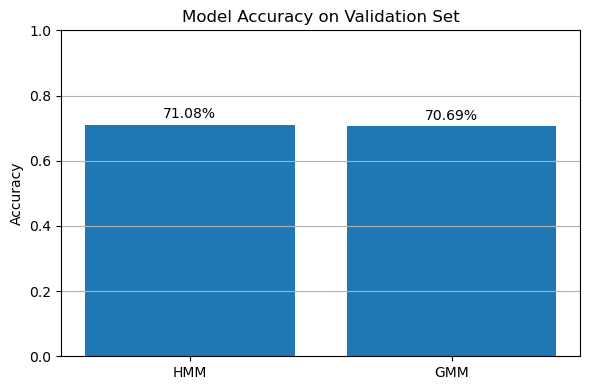

In [20]:
# 📊 Plotting the accuracy score of both models
plt.figure(figsize=(6, 4))
models = ["HMM", "GMM"]
accuracies = [acc_hmm, acc_gmm]
bars = plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.title("Model Accuracy on Validation Set")
plt.ylabel("Accuracy")
plt.grid(axis='y')

# Highlight's values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [4]:
# Loading trained models
with open(r"C:\Users\Daivik\Desktop\NLP-sem-2\Best Project\Trained models\hmm_models.pkl", "rb") as f:
    hmm_models = pickle.load(f)

with open(r"C:\Users\Daivik\Desktop\NLP-sem-2\Best Project\Trained models\gmm_models.pkl", "rb") as f:
    gmm_models = pickle.load(f)

This `predict_live()` function is responsible for performing real-time word prediction based on a recorded speech signal. It first extracts features from the input signal (live audio) including MFCC, as well as delta and delta², which capture the dynamic aspects of speech. These features are then normalized to ensure consistency across recordings. After that function evaluates the likelihood of the extracted features against each trained Hidden Markov Model (HMM) and Gaussian Mixture Model (GMM) to determine which word the signal most closely resembles.

In [5]:
DURATION = 2  # Length of audio to be recorded from the microphone
SAMPLE_RATE = 16000
N_MFCC = 13

# Adding this normalization function so I don't have to run the entire notebook again.
def normalize_features(mfcc, delta, delta2):
    features = np.concatenate((mfcc, delta, delta2), axis=1)
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Predicting function for both models
def predict_live(signal, hmm_models, gmm_models):
    mfcc = librosa.feature.mfcc(y=signal, sr=SAMPLE_RATE, n_mfcc=N_MFCC).T
    width = max(3, (min(9, mfcc.shape[0]) // 2) * 2 + 1)
    delta = librosa.feature.delta(mfcc.T, width=width).T
    delta2 = librosa.feature.delta(mfcc.T, order=2, width=width).T
    features = normalize_features(mfcc, delta, delta2)

    hmm_scores = {label: model.score(features) for label, model in hmm_models.items()}
    gmm_scores = {label: model.score(features) for label, model in gmm_models.items()}

    hmm_pred = max(hmm_scores, key=hmm_scores.get)
    gmm_pred = max(gmm_scores, key=gmm_scores.get)

    print(f"🧠 HMM Prediction: {hmm_pred}")
    print(f"🧠 GMM Prediction: {gmm_pred}")

This `live_predict` function enables real-time speech prediction using a microphone. It records audio input for a fixed duration (e.g., 1.5 seconds), normalizes the signal for uniform processing, and then passes it to the function. This function extracts MFCC-based features from the signal and uses both trained HMM and GMM models to classify the spoken word.

In [17]:
# Recording and predicting
def live_predict():
    print("🎙️ Recording... Speak now!")
    recording = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    print("✅ Recording finished.")

    signal = recording.flatten()
    signal = signal / np.max(np.abs(signal))  # Normalize between -1 and 1

    predict_live(signal, hmm_models, gmm_models)

# Run prediction
live_predict()

🎙️ Recording... Speak now!
✅ Recording finished.
🧠 HMM Prediction: bed
🧠 GMM Prediction: go


## **Conclusion**

This project effectively demonstrated the development of a fundamental speech recognition system using classical machine learning approaches—specifically, Hidden Markov Models (HMM) and Gaussian Mixture Models (GMM). Through systematic audio preprocessing and feature extraction, we achieved approximately 71% accuracy in live word prediction, validating the capability of traditional models in limited-vocabulary scenarios. The implementation deepened our understanding of speech signal processing, sequence modelling, and statistical classification. Moreover, it underscored the relevance of foundational techniques in resource-constrained environments and provided a solid platform for future enhancements involving neural networks, larger vocabularies, and real-time applications.